In [1]:
import cv2
import numpy as np
try:
  cv2.imshow()
  show=cv2.imshow
except:
  from google.colab.patches import cv2_imshow as show

In [21]:
pxls=100
blackPxls=0.5
th=90

In [19]:
def preprocess(img):
  img=np.array(img,np.int32)
  shp=(400,400)
  for r in range(shp[0]):
    for c in range((img.shape[1])):
      if r ==0 and c==0:
        img[r][c]=img[r][c]>th
      elif r==0 and c:
        img[r][c]=img[r][c-1]+(img[r][c]>th)
      elif c==0 and r:
        img[r][c]=img[r-1][c]+(img[r][c]>th)
      else:
        img[r][c]=img[r-1][c]+img[r][c-1]-img[r-1][c-1]+(img[r][c]>th)
  for r in range(shp[0],img.shape[0]):
    for c in range((shp[1])):
      if r ==0 and c==0:
        img[r][c]=img[r][c]>th
      elif r==0 and c:
        img[r][c]=img[r][c-1]+(img[r][c]>th)
      elif c==0 and r:
        img[r][c]=img[r-1][c]+(img[r][c]>th)
      else:
        img[r][c]=img[r-1][c]+img[r][c-1]-img[r-1][c-1]+(img[r][c]>th)
  return img
def ratioBlack(img,r,c,h,w):
  h-=1
  w-=1
  sm=0
  if r ==0 and c==0:
    sm= img[h][w]
  elif r==0 and c:
    sm= img[h][c+w]- img[h][c-1]
  elif c==0 and r:
    sm= img[r+h][w]-img[r-1][w]
  else:
    sm= img[r+h][c+w]-img[r-1][c+w]-img[r+h][c-1]+img[r-1][c-1]
  total=((h+1)*(w+1))
  return 1-sm/total;

In [4]:
def convoluteShort(on,kernelShape):
  
  if on.shape[0]<200 or on.shape[1]<200:
    return 1

  y_len=kernelShape[0]
  x_len=kernelShape[1]
  y_from,x_from=0,0
  done=False
  for y in range(100):
    for x in range(100):
      res=ratioBlack(on,y,x,y_len,x_len)
      if res>blackPxls:
        y_from,x_from=(y+y_len,x+x_len)
        done=True
        break
    if done:
      break

  # try:
  while(ratioBlack(on,y_from,x_from,5,5)>blackPxls):
    x_from+=2
  x_from-=2
  while(1-ratioBlack(on,y_from,x_from,2,pxls)>blackPxls):
    y_from+=1
  return y_from,x_from
  # except:
  #   return 2


def nextHorizontalShort(on,y_prev,x_prev):
  y_prev+=30
  y_from=y_prev
  x_from=x_prev
  while(ratioBlack(on,y_from,x_from,5,pxls)>blackPxls):
      y_from+=1
  while(1-ratioBlack(on,y_from,x_from,5,pxls)>blackPxls):
      y_from+=1
  return y_from,x_from

def nextVerticalShort(on,y_prev,x_prev):
  x_prev+=30
  y_from=y_prev
  x_from=x_prev
  while(ratioBlack(on,y_from,x_from,pxls,5)>blackPxls):
    x_from+=1
  while(1-ratioBlack(on,y_from,x_from,pxls,5)>blackPxls):
      x_from+=1
  return y_from,x_from

In [5]:
def rotate(img,angle):
  rows = img.shape[0]
  cols = img.shape[1]

  img_center = (cols / 2, rows / 2)
  M = cv2.getRotationMatrix2D(img_center, angle, 1)

  rotated_image = cv2.warpAffine(img, M, (cols, rows),
                            borderMode=cv2.BORDER_CONSTANT,
                            borderValue=(255,255,255))
  return rotated_image

In [6]:
import tensorflow as tf
from tensorflow import keras

In [7]:
def getAllCells(hori,ver,on):
  starts=[]
  for y in range(len(hori)-1):
    for x in range(len(ver)-1):
      leftTop=hori[y][0],ver[x][1]
      rightEnd=hori[y+1][0],ver[x+1][1]
      starts.append((leftTop,rightEnd))
  return starts

In [8]:
def giveHoriVer(marked):
  for ii in np.arange(0,5):
      for i in [ii,-(ii)]:
        global done
        done=False
        if i:
          timg=rotate(marked,i)
        else: 
          timg=marked
        img=preprocess(timg)
        try:
          leftEndpoint=convoluteShort(img,(30,30))
          horizontal=[leftEndpoint]
          vertical=[leftEndpoint]
          while(len(horizontal)<10):
            horizontal.append(nextHorizontalShort(img,horizontal[-1][0],horizontal[-1][1]))
          while(len(vertical)<8):
            vertical.append(nextVerticalShort(img,vertical[-1][0],vertical[-1][1]))
          done=True
          marked=timg
          break
        except:
          if ii==0:
            break
      if done :
        break
  # print(done)
  if not done:
    raise "not good image"
  else:
    return horizontal,vertical,marked

In [9]:
def extractImg(img,x1,y1,x2,y2):
  x1=x1-10
  y1=y1-10
  x2=x2+10
  y2=y2+10
  trimmed=img[y1:y2,x1:x2,np.newaxis]
  trimmed=tf.image.resize([trimmed],(224,224))
  trimmed=tf.image.grayscale_to_rgb(trimmed)
  return trimmed[0]

In [10]:
def getSubImgs(marked):
  horizontal,vertical,marked=giveHoriVer(marked)
  allBlocks=getAllCells(horizontal,vertical,marked)
  cells=marked.copy()
  subImgs=[]
  for lt,rb in allBlocks:
    cv2.rectangle(cells,lt[::-1],rb[::-1],100,2)
    subImgs.append(extractImg(marked,lt[1],lt[0],rb[1],rb[0]))
  subImgs=tf.convert_to_tensor(subImgs)
  return subImgs

In [11]:
def readImgGray(filename):
  imgGrid=cv2.imread(filename,cv2.IMREAD_GRAYSCALE)
  return cv2.resize(imgGrid,(600,800),interpolation=cv2.INTER_AREA)

In [12]:
def preprocessForVGG(marked):
  subImgs=getSubImgs(marked)
  return vgg.preprocess_input(subImgs)

In [13]:
import tensorflow.keras.applications.vgg16  as vgg
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer,Flatten,Dropout,Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras import layers, models, Model, optimizers
from sklearn.model_selection import train_test_split as tts

In [14]:
%tensorflow_version 2.x
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.7.0
Running on TPU  ['10.13.180.26:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.13.180.26:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.13.180.26:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [15]:
cellStates=['empty','present','absent']

In [73]:
def createData(imgName,stt):
  subImgs=[]
  states=[]
  assert len(imgName)==len(stt)
  for f,s in zip(imgName,stt):
    si=preprocessForVGG(readImgGray(f))
    sos=tf.constant(si.shape[0]*[s],tf.uint8)
    subImgs.extend(si)
    states.extend(sos)
  return subImgs,states

In [74]:
subImgs,states=createData(["grid.png","handA.png","handP.png","excel.png","excelA.png"],[0,2,1,1,2])

In [47]:
def giveModel():
  model=vgg.VGG16(weights='imagenet',include_top=False,input_shape=(224, 224, 3))
  for layer in model.layers[:15]:
    layer.trainable=False
  x=model.output
  x=Flatten()(x)
  x=Dense(512,activation='relu')(x)
  x=Dropout(0.5)(x)
  x=Dense(256,activation='relu')(x)
  x=Dense(3,activation='softmax')(x)
  Attendance_model=Model(inputs=model.input,outputs=x)
  return Attendance_model

In [60]:
Attendance_model=giveModel()

In [61]:
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
checkpoint = ModelCheckpoint('vgg16_finetune.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

In [62]:
learning_rate= 5e-5
Attendance_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy"])

In [51]:
def createDataSet(X,y,is_training=False):
  ds=tf.data.Dataset.from_tensor_slices((X,y))
  ds=ds.batch(32).prefetch(32)
  if is_training:
    ds=ds.shuffle(32)
  return ds

In [52]:
X=np.array(subImgs)
y=np.array(states)

In [53]:
X_train,X_test,y_train,y_test=tts(X,y,test_size=0.25,random_state=42,shuffle=True)

In [57]:
train_ds=createDataSet(X_train,y_train,True)
val_ds=createDataSet(X_test,y_test,True)

In [63]:
history = Attendance_model.fit(train_ds, epochs=20,validation_data=val_ds,callbacks=[lr_reduce])

Epoch 1/20
8/8 [==============================] - 6s 617ms/step - loss: 3.2824 - accuracy: 0.5000 - val_loss: 0.4540 - val_accuracy: 0.8354 - lr: 5.0000e-05
Epoch 2/20
8/8 [==============================] - 4s 567ms/step - loss: 0.7316 - accuracy: 0.7797 - val_loss: 0.6169 - val_accuracy: 0.8228 - lr: 5.0000e-05
Epoch 3/20
8/8 [==============================] - 4s 566ms/step - loss: 0.4573 - accuracy: 0.8941 - val_loss: 0.2780 - val_accuracy: 0.8987 - lr: 5.0000e-05
Epoch 4/20
8/8 [==============================] - 4s 565ms/step - loss: 0.2244 - accuracy: 0.9364 - val_loss: 0.1171 - val_accuracy: 0.9747 - lr: 5.0000e-05
Epoch 5/20
8/8 [==============================] - 5s 584ms/step - loss: 0.0538 - accuracy: 0.9831 - val_loss: 0.1632 - val_accuracy: 0.9367 - lr: 5.0000e-05
Epoch 6/20
8/8 [==============================] - 5s 567ms/step - loss: 0.0488 - accuracy: 0.9915 - val_loss: 0.2802 - val_accuracy: 0.9241 - lr: 5.0000e-05
Epoch 7/20
8/8 [==============================] - 5s 582ms

In [66]:
Attendance_model.evaluate(val_ds)

3/3 [==============================] - 1s 320ms/step - loss: 0.0219 - accuracy: 1.0000


[0.021947743371129036, 1.0]

In [67]:
import pickle

In [70]:
weights=Attendance_model.get_weights()

In [71]:
pickle.dump(weights,open("AttWeights.pkl","wb"))

In [164]:
def imgWithLabel(img,model,labels):
  pred=tf.argmax(model.predict(np.array([img])),axis=1)[0].numpy()
  try:
    image = cv2.putText(img.numpy(), labels[pred], (20,20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0),  2, cv2.LINE_AA)
  except:
    image = cv2.putText(img, labels[pred], (20,20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0),  2, cv2.LINE_AA)
  return image

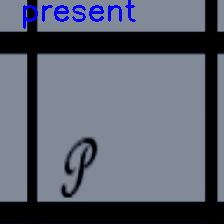

None

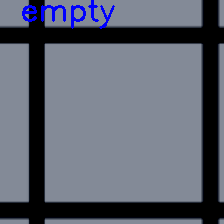

None

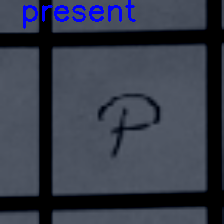

None

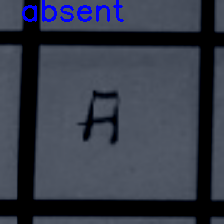

None

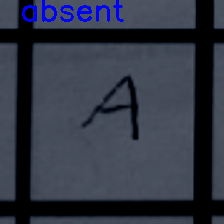

None

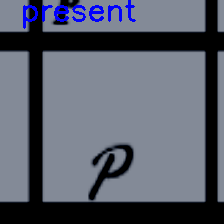

None

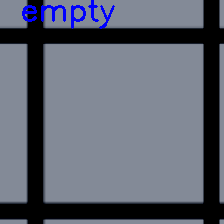

None

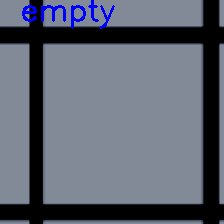

None

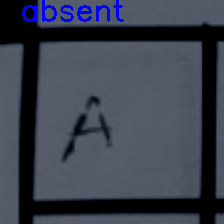

None

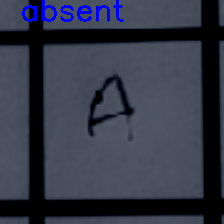

None

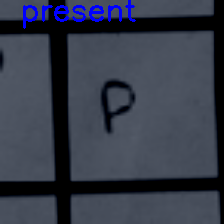

None

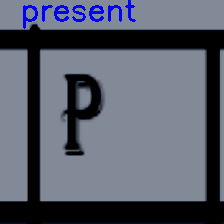

None

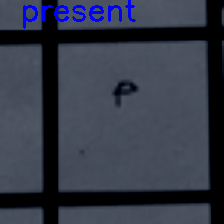

None

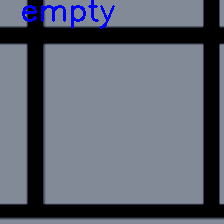

None

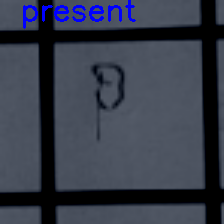

None

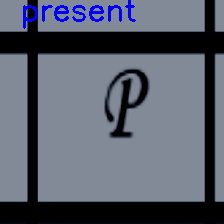

None

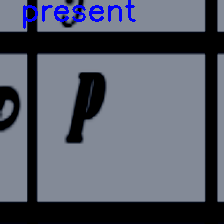

None

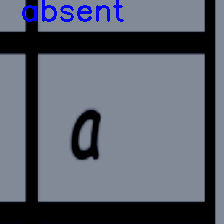

None

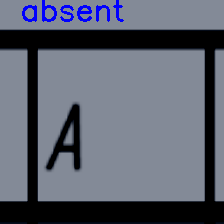

None

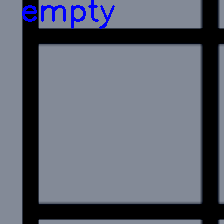

None

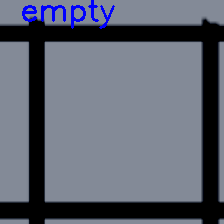

None

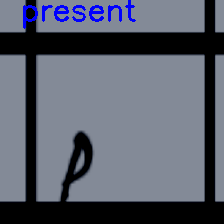

None

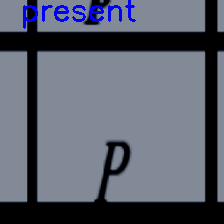

None

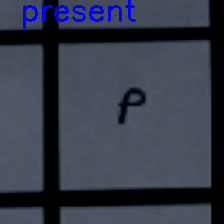

None

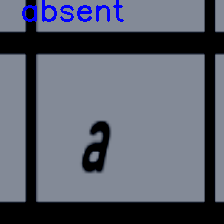

None

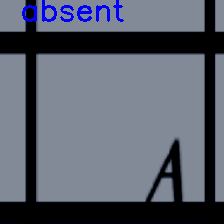

None

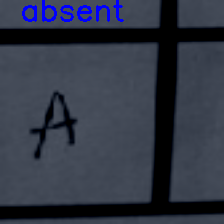

None

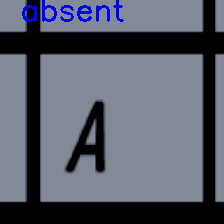

None

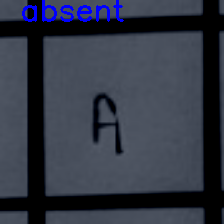

None

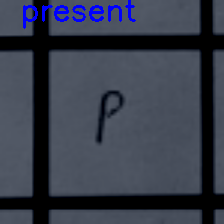

None

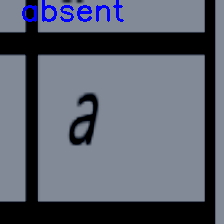

None

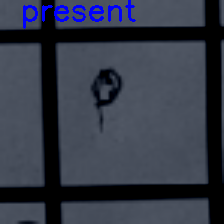

None

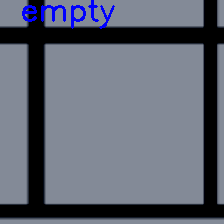

None

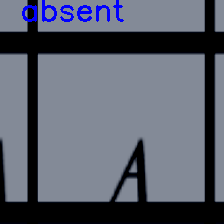

None

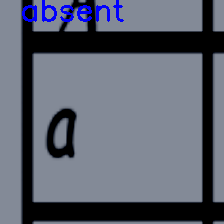

None

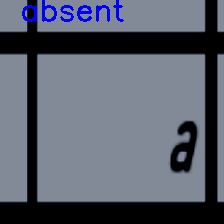

None

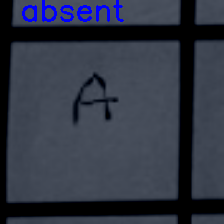

None

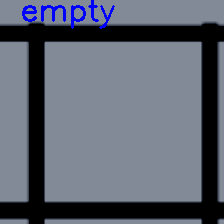

None

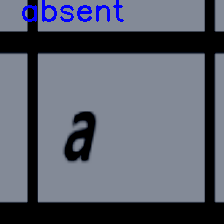

None

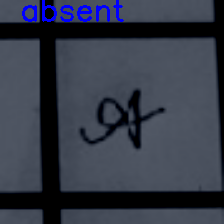

None

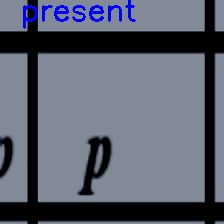

None

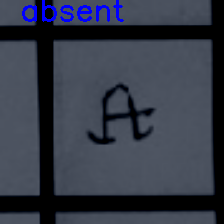

None

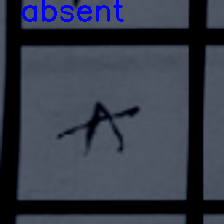

None

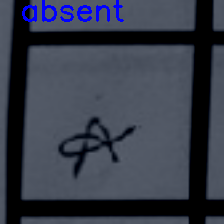

None

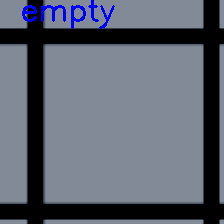

None

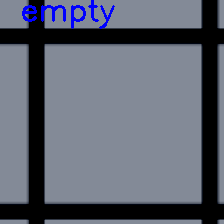

None

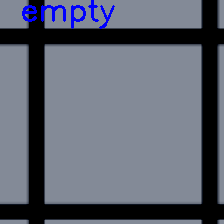

None

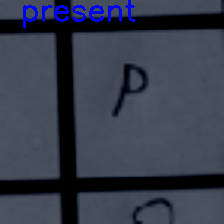

None

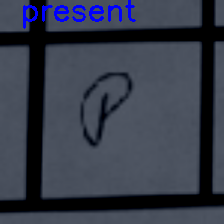

None

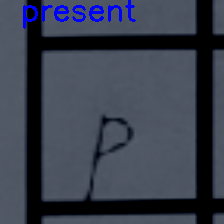

None

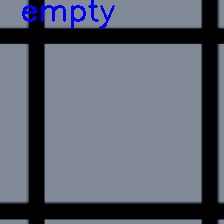

None

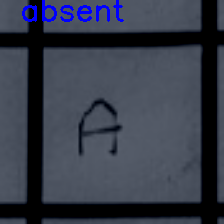

None

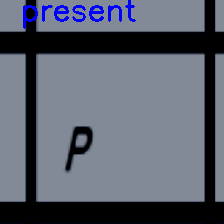

None

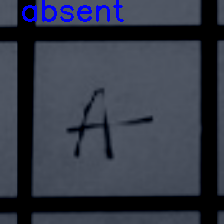

None

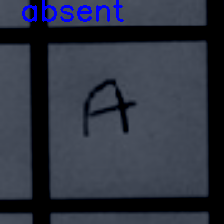

None

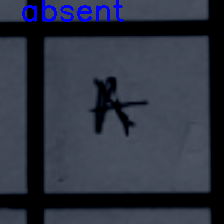

None

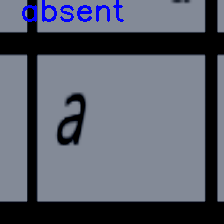

None

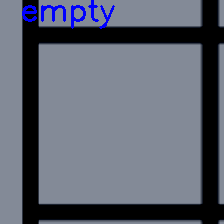

None

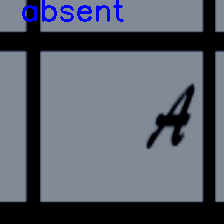

None

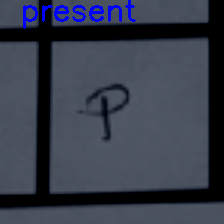

None

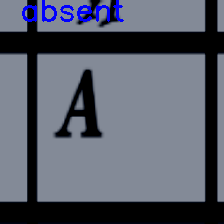

None

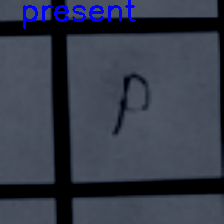

None

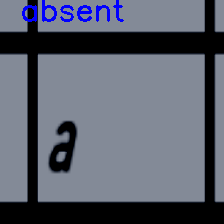

None

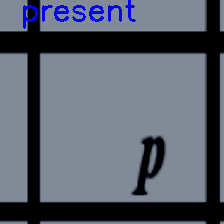

None

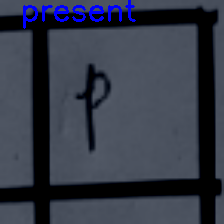

None

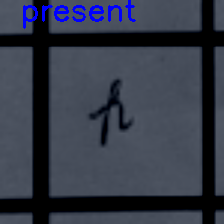

None

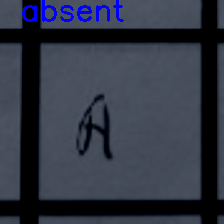

None

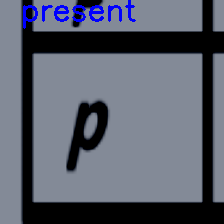

None

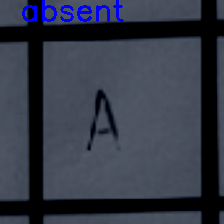

None

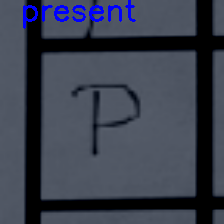

None

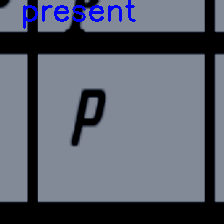

None

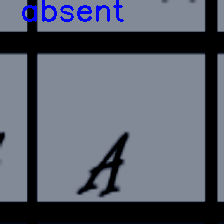

None

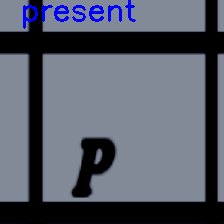

None

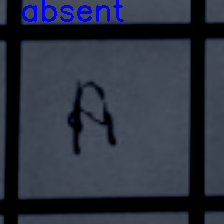

None

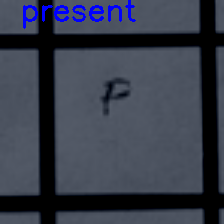

None

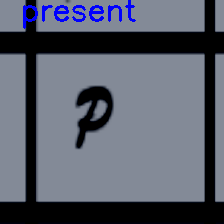

None

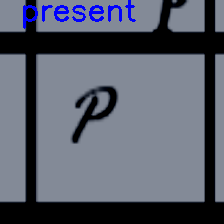

None

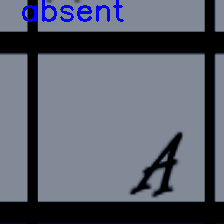

None

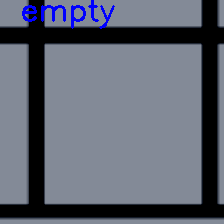

None

In [165]:
for i in X_test:
  display(show(imgWithLabel(i,Attendance_model,cellStates)))

In [153]:
tf.argmax(Attendance_model.predict(np.array(img)),axis=1)

<tf.Tensor: shape=(63,), dtype=int64, numpy=
array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])>